# Lab Assignment 2 of IMAGE SIGNAL PROCESSING
**Mansi Kakkar**
**EE21S063**

# Occlusion Detection



Libraries Imported

imageio : for reading the image

math : for implying floor function

numpy : for finding size of image

matplotlib : for plotting the function

In [1]:
import imageio as io
import math
import numpy as np
import matplotlib.pyplot as plt


In [5]:
!ls

IMG1.png IMG2.png


**Reading Image 1**


Text(0.5, 1.0, 'IMG 1')

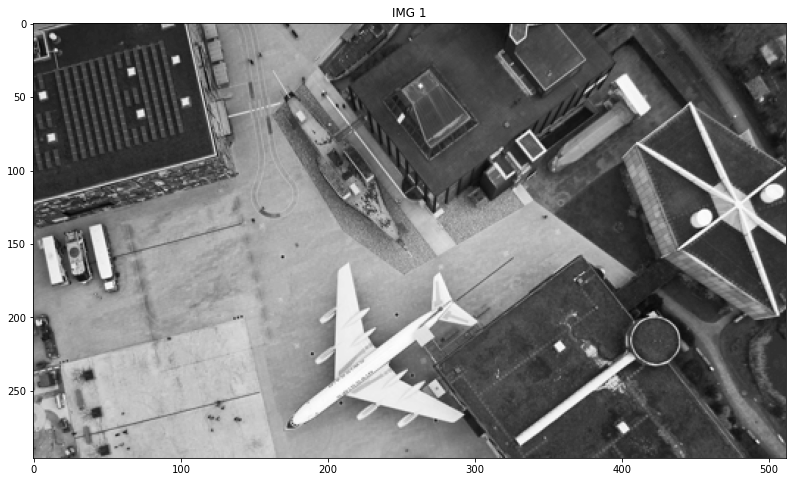

In [6]:
img1=io.imread('IMG1.png')
#Plot of image 1
plt.figure(figsize=(16,8))
plt.imshow(img1,'gray')
plt.title('IMG 1')

**Reading Image 2**

Text(0.5, 1.0, 'IMG 2')

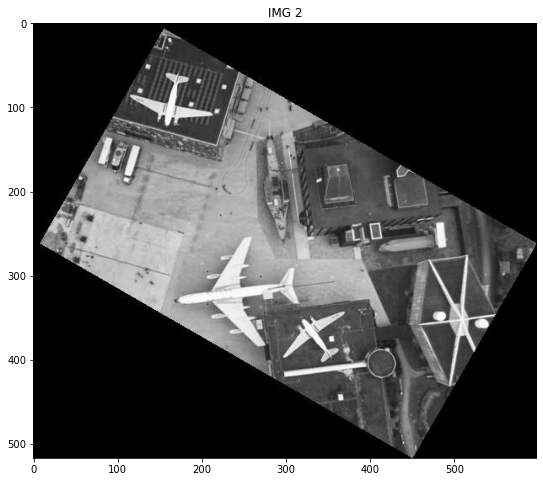

In [7]:
img2=io.imread('IMG2.png')
#Plot of image 2
plt.figure(figsize=(16,8))
plt.imshow(img2,'gray')
plt.title('IMG 2')


Getting size of image 1

In [8]:
img1.shape

(296, 512)

Getting size of image 2

In [9]:
img2.shape

(517, 598)

**Bilinear Interpolation**

Applying bilinear interpolation for filling out the intensities for source values corresponding to target values.

In [10]:
#FUNCTION FOR BILINEAR INTERPOLATION

def bilinear_interpolation(source,x,y):
    
    #taking coordinates of zero padded image
    xz,yz=np.shape(source)
    #original coordinates of image
    xz=xz-2 
    yz=yz-2
    
    #taking x+1 and y+1 since coordinates have to be aligned to the zero padded image
    #zero padded image has one coordinate +1 due to padding hence target image coordinate is incremented by 1
    x=x+1
    y=y+1
    
    #defining x',y' as floor of x,y 
    x_prime=math.floor(x)
    y_prime=math.floor(y)
    #defining a,b as distance of target point from floor points
    a=x-x_prime
    b=y-y_prime
    
    if x_prime>=0 and x_prime<=xz and y_prime>=0 and y_prime<=yz:
        #calculating the intensity at the target
        intensity = (1-a)*(1-b)*source[x_prime,y_prime]+(1-a)*b*source[x_prime,y_prime+1]+a*(1-b)*source[x_prime+1,y_prime]+a*b*source[x_prime+1,y_prime+1]
        #converting intensity into integer as intensity value cannot be float
        intensity=int(intensity)
    else:
        #when xs and ys are not defined i.e. xs and ys are <0 for corresponding target location
        intensity = 0

    return intensity

**STEPS TO FIND THE SIMILIARITY IN IMAGE 1 AND IMAGE 2 ON THE BASIS OF GIVEN POINTS ON IMAGE 1 AND POINTS CORRESPONDING TO THEM IN IMAGE 2 BY HOMOGRAPHY MATRIX**

1. Defining the points on image 1 and their corresponding points on image 2

2. Defining a Matrix A, which we get by simplifying the homography matrix $H$, such that we get $Ah = 0$

     $ \begin{bmatrix} x'\\y'\\1 \end{bmatrix} = \begin{bmatrix} h_{11} & h_{12} & h_{13}\\h_{21} & h_{22} & h_{23}\\h_{31} & h_{32} & h_{33} \end{bmatrix}\begin{bmatrix} x\\y\\1 \end{bmatrix}$

     Given, that the images are related by in-plane rotation and translation
   Then we get, $ H=   \begin{bmatrix} \cos(\theta) & \sin(\theta) & t_x \\ -\sin(\theta) & \cos(\theta) & t_y\\0 & 0 & 1 \end{bmatrix}$
   
     Using the property of scaling factor in $H$ we get, $ H=   \begin{bmatrix} k \cos(\theta) & k \sin(\theta) & k t_x \\ -k \sin(\theta) & k \cos(\theta) & k t_y\\0 & 0 & k \end{bmatrix}$

     Taking all of these as indivisual values we can replace each by different variables, hence writing $H$ as, $ H=   \begin{bmatrix} a & b & c \\ -b & a & d\\0 & 0 & h \end{bmatrix}$

     Now , we get , $ x_i'= \frac{ax_i+bx_i+c}{h} \\ y_i' = \frac{-bx_i+y_i+d}{h}$
    Simplifying we get , $A_i \bar h = 0 $
    
     $ A_i= \begin{bmatrix} x_i & y_i & 1 & 0 & -x_i' \\ y_i & x_i & 0 & 1 & -y_i'\end{bmatrix}$
       
     $ \bar h = \begin{bmatrix} a & b & c & d & h \end{bmatrix}^T$
       
                       


In [11]:
#Defining the points of image 1 and their corresponding points on image 2

pts=np.array([[29,124],[157,372]])
corr_pts=np.array([[93,248],[328,399]])
assert len(pts)==len(corr_pts) ,"Mismatch in Number of Points"
num_corr=len(pts)

#Defining matrix A
A_matrix=np.zeros((2*num_corr,5))
for i in range(num_corr):
    #Since, perfroming target to source mapping , replacing x,y = pts by corr_pts and similiar for x',y'
    x, y = corr_pts[i]
    x_prime, y_prime = pts[i]
    #Defining A Matrix
    A_matrix[2*i] = [x, y, 1, 0, -x_prime]
    A_matrix[2*i+1] = [y, -x, 0, 1, -y_prime]
    


**HOMOGRAPHY**

From the A matrix, we can rederive $H$ using Singular Value Decomposition ( SVD )
Extracting $U$, $\sum$ or $S$, and $V^T$ from A and substituting the last row of $V^T$ to a, b, c, d, h and using them in $H$ matrix.

In [12]:
#HOMOGRAPHY
u, s, v_transpose = np.linalg.svd(A_matrix)
a, b, c, d, h = v_transpose[-1]
H = np.array([[a, b, c],[-b, a, d],[0, 0, h]]).reshape(3,3)


**TRANSFORM FUNCTION**

Transforming the source image using H matrix. 

Using $H^{-1}$ instead of $H$ since we are performing target to source mapping

In [13]:
def transform_image(source, H):
    #reading image size
    x,y = np.shape(source)
    #creating a blank image
    new_img = np.zeros((x,y))
    #zero padded source image
    zero_padded_image = np.zeros((x+2,y+2))
    zero_padded_image[1:-1, 1:-1] = source
    
    H_inv = np.linalg.inv(H)
    
    for xt in range(x):
        for yt in range(y):
            vt = np.array([xt,yt,1])
            xs,ys = corresponding_points(H_inv,vt)
            intensity=bilinear_interpolation(zero_padded_image, xs, ys)
            new_img[xt,yt]=intensity
    return new_img

**Finding Corresponding Coordinate Points**


Defining the function to calculate the coordinates in the transformed image corresponding to coordinates (x,y) in the original image when the homography matrix is H.

In [14]:
 def corresponding_points(H, x):
        x_prime = H@x
        if x_prime[-1]!=0:
            return x_prime[0]/x_prime[-1], x_prime[1]/x_prime[-1]
        else:
            return 0, 0
        
        

# RESULTS

**OUTPUT**


Applying Transformation on Image 2

Text(0.5, 1.0, 'Transformed image (IMG2)')

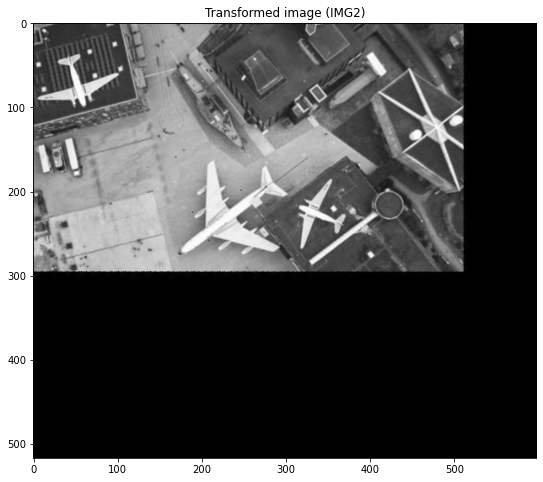

In [15]:
new_img=transform_image(img2, H)
plt.figure(figsize=(16,8))
plt.imshow(new_img,'gray')
plt.title('Transformed image (IMG2)')


**CROPPING**

Cropping the above image to get image of size just as image 1 so that operation of comparison can be performed

Text(0.5, 1.0, 'Transformed and Cropped (IMG2)')

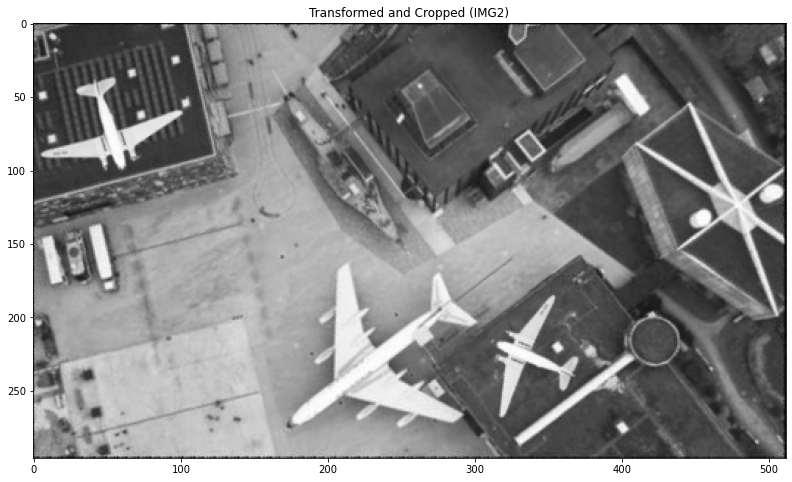

In [16]:
x_b, y_b = np.shape(img1)
new_image = new_img[:x_b, :y_b]
plt.figure(figsize=(16,8))
plt.imshow(new_image,'gray')
plt.title('Transformed and Cropped (IMG2)')


**DIFFERENCES**

Subtracting image 1 from image 2

Text(0.5, 1.0, 'difference of both the images')

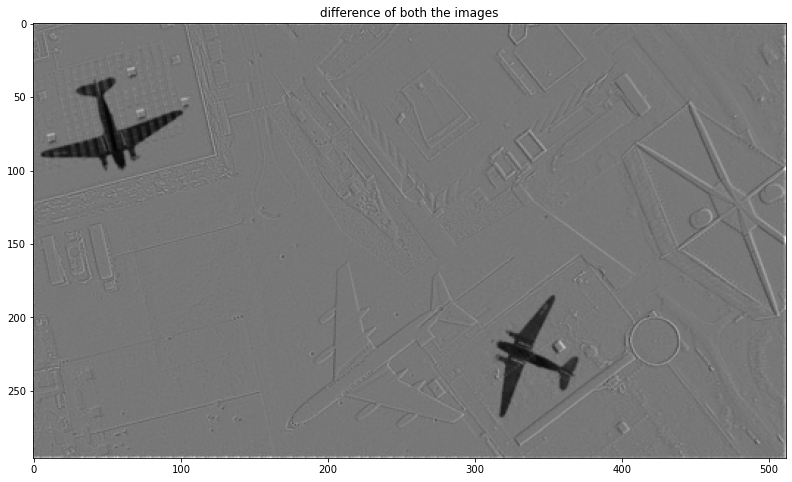

In [17]:
diff = img1-new_image
plt.figure(figsize=(16,8))
plt.imshow(diff,'gray')
plt.title('difference of both the images')

**OBSERVATIONS**


We can make the following observations: 
1. The image 2 given, only suffered in - plane translation and rotation, thus homography matrix only comprised of these variations.
2. While performing the transform on image 2 if rather it would have been performed on image 1 then results would have been inappropriate. 
3. Similiarly, while defining the matrix A, it should not be confused with the fact that although x,y are pts (points) of image 1 i.e. original image and x', y' are corr_pts (corresponding points) of image 2, substitutions should be reversed because we are performing target ot source mapping leading to reversal of allocations.
4. We can observe in the difference section that the grey area represents the part of image that is completely same and the black portion of the image is the bit that is present in image 2 but not in 1.

Thus after proper alignment of two given images using homoraphy and then taking the difference we can detect the extra or missing bits by comparing two images by this method
